# Evaluate water mass properties on the shelves using Shenjie's climatology

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')

from nemo_python_git.file_io import read_dutrieux, read_zhou
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.plots import circumpolar_plot, finished_plot

In [3]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test6/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [13]:
ds1 = xr.open_dataset(f'{base_dir}output/ERA5_test6/files_spinup/eANT025.L121_1m_19910101_19911231_grid_T.nc')
ds2 = xr.open_dataset(f'{base_dir}output/ERA5_icebergs_off/files/eANT025.L121_1m_19910101_19911231_grid_T.nc')
ds3 = xr.open_dataset(f'{base_dir}output/ERA5_airseadrag/files_drag6e-3/eANT025.L121_1m_19880101_19881231_grid_T.nc')
ds4 = xr.open_dataset(f'{base_dir}output/ERA5_test6/files_spinup/eANT025.L121_1m_19880101_19881231_grid_T.nc')

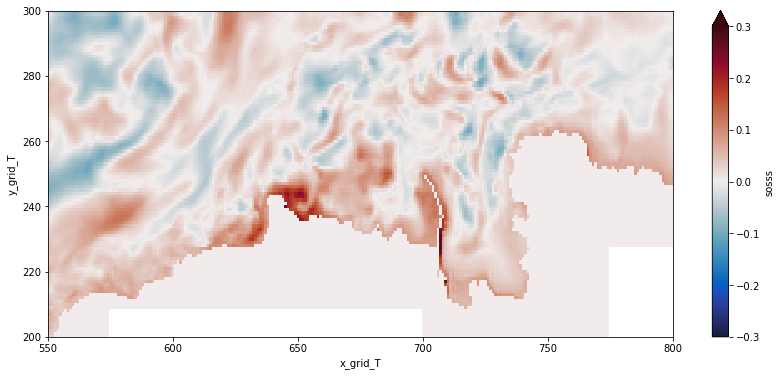

In [12]:
(ds2.sosss - ds1.sosss).mean(dim='time_counter').plot(figsize=(14,6), xlim=(550,800), ylim=(200,300), 
                                                      vmin=-0.3, vmax=0.3, cmap=cmocean.cm.balance)

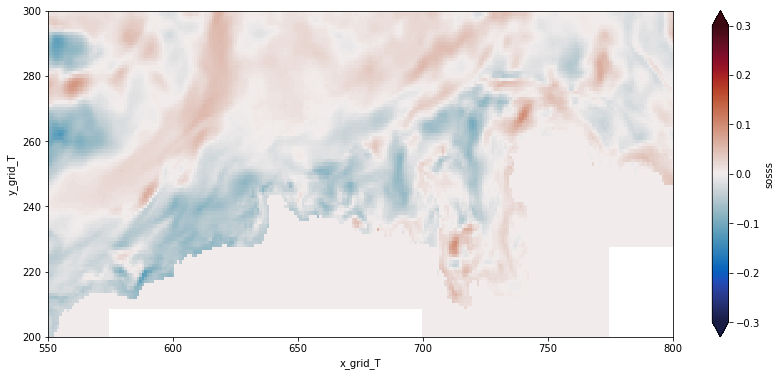

In [16]:
(ds3.sosss - ds4.sosss).mean(dim='time_counter').plot(figsize=(14,6), xlim=(550,800), ylim=(200,300), 
                                                      vmin=-0.3, vmax=0.3, cmap=cmocean.cm.balance)

## Look at Shenjie Zhou's observational dataset
- create an evaluation of the specified depth slice circumpolar for simulation and observations

In [22]:
# Compare temperature and salinity in a depth range in NEMO (time-averaged over the given xarray Dataset) to observations: 
# Specifically, Shenji Zhou's 2024 dataset
def circumpolar_TS_vs_obs (nemo, target_depth=100, bottom=False, lat_max=-50, 
                           nemo_mesh='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'):
    
    # depth is the depth to look at (could be a slice):
    obs       = read_zhou()
    obs_zhou  = obs.drop(['lon', 'lat', 'pressure']).rename_dims({'y':'lat', 'x':'lon'})
    if bottom:
        # find values at the deepest temperature in the dataset
        land_values    = (np.isnan(obs_zhou.ConsTemp))
        bottom_indices = (obs_zhou.z.size - land_values.sum(dim='z') - 1)
        obs_zhou       = obs_zhou.sel(z=xr.DataArray(bottom_indices.values, dims=("lon","lat")))
        # Regrid to the NEMO grid
        nemo_plot = xr.Dataset({'ConsTemp':nemo['sbt'], 'AbsSal':nemo['sbs']})
    else:
        # select depth level nearest the specified depth
        obs_ind  = np.argmin(np.abs(obs.isel(x=0,y=0).depth - target_depth).values)
        nemo_ind = np.argmin(np.abs(nemo.isel(x=0,y=0).deptht - target_depth).values)
    
        obs_zhou  = obs_zhou.isel(z=obs_ind)
        # Regrid to the NEMO grid
        nemo_plot = xr.Dataset({'ConsTemp':nemo['thetao'].isel(deptht=nemo_ind), 'AbsSal':nemo['so'].isel(deptht=nemo_ind)})
        
    obs_zhou  = obs_zhou.assign_coords({'lat':obs.lat.isel(x=0).values, 'lon':obs.lon.isel(y=0).values}).transpose()
    print('Interpolating Zhou 2024 dataset to grid')
    obs_plot  = interp_latlon_cf(obs_zhou, nemo_plot, method='bilinear')
    print('finished interpolation')

    nemo_plot = nemo_plot.where(nemo_plot['ConsTemp']!=0) # Apply NEMO land mask to both
    obs_plot  = obs_plot.where(nemo_plot['ConsTemp'].notnull()*obs_plot.notnull())
    obs_plot  = obs_plot.where(nemo_plot['ConsTemp']!=0)
    if bottom:
        obs_not_plot  = obs_plot.where((np.abs(obs_plot.depth - domcfg.bathy_metry) > 300)|(obs_plot==0))
        obs_plot      = obs_plot.where(np.abs(obs_plot.depth - domcfg.bathy_metry) <= 300).where((obs_plot!=0)*(nemo_plot['ConsTemp']!=0))

    land_plot = xr.where((domcfg.bottom_level == 0), 1, np.nan)
    nemo_plot = nemo_plot.where((obs_plot!=0)*(nemo_plot['ConsTemp']!=0))
    # Get difference from obs
    bias = nemo_plot - obs_plot

    print('Creating figure')
   # Make the plot
    fig = plt.figure(figsize=(10,7), dpi=150)
    gs = plt.GridSpec(2,3)
    gs.update(left=0.1, right=0.9, bottom=0.05, top=0.95, hspace=0.2, wspace=0.1)
    data_plot = [nemo_plot, obs_plot, bias]
    var_plot = ['ConsTemp', 'AbsSal']
    var_titles = ['Temperature', 'Salinity']
    if bottom:
        alt_titles = ['Simulations at sea floor','Deepest observations','Model bias']
    else:
        alt_titles = [f'Simulations \n {nemo.deptht.isel(deptht=nemo_ind).values:.0f} m', \
                      f'Observations \n {np.abs(obs.depth.isel(x=0,y=0,z=obs_ind).values):.0f} m', \
                      'Model bias']
    vmin = [-2, -2, -0.8, 34, 34, -0.2]
    vmax = [2, 2, 0.8, 35, 35, 0.2]
    cmap = cmocean.cm.balance  # viridis is the default colormap for imshow
    ctype = [cmap, cmap, cmap] 
    i=0
    for v in range(2):
        for n in range(3):
            ax = plt.subplot(gs[v,n])
            ax.axis('equal')
            img = circumpolar_plot(data_plot[n][var_plot[v]], nemo, ax=ax, masked=True, make_cbar=False, lat_max=lat_max, 
                                   title=alt_titles[n], vmin=vmin[i], vmax=vmax[i], ctype=ctype[n], shade_land=True)
            img2 = circumpolar_plot(obs_not_plot['ConsTemp'], nemo, ax=ax, masked=True, make_cbar=False, lat_max=lat_max, 
                                   title=alt_titles[n], ctype=cmocean.cm.gray, vmin=-10, vmax=10, shade_land=False)
            # img3 = circumpolar_plot(land_plot, nemo, ax=ax, masked=True, make_cbar=False, lat_max=lat_max, 
            #                        title=alt_titles[n], ctype=cmocean.cm.gray, vmin=-10, vmax=10, shade_land=False)
            
            i+=1
            if n != 1:
                cax = fig.add_axes([0.01+0.46*n, 0.58-0.48*v, 0.02, 0.3])
                plt.colorbar(img, cax=cax, extend='both' if n==0 else 'neither', label=var_titles[v])
    
    # finished_plot(fig, fig_name=fig_name, dpi=dpi)

In [17]:
a = np.arange(1979,2015)
print(a[:10])

[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988]


In [5]:
file_list = glob.glob(f'{run_folder}files/eANT025.L121_1m_20*_grid_T*.nc')
# sim    = xr.open_mfdataset(file_list)
sim    = xr.open_dataset(file_list[10])
sim    = sim.isel(time_counter=(sim.time_counter.dt.month==1) | (sim.time_counter.dt.month==2)).mean(dim='time_counter')
sim_ds = sim.rename({'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                     'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat',
                     'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                     'nvertex_grid_T':'nvertex'})

sim_ds = sim_ds.drop(['area', 'deptht_bounds', 'zos', 'mldr10_1', 'sbt','sbs','sosst', 'sosss'])
sim_ds = sim_ds.assign({'sbt':sim.sbt.rename({'x_grid_T_inner':'x','y_grid_T_inner':'y'}), 
                        'sbs':sim.sbs.rename({'x_grid_T_inner':'x','y_grid_T_inner':'y'})})
# sim_ds = sim_ds.drop(['area', 'deptht_bounds', 'zos', 'mldr10_1', 'sbt', 'sbs', 'sosst', 'sosss', 'thkcello']) 

In [6]:
domcfg = xr.open_dataset(nemo_domain).isel(time_counter=0)

Interpolating Zhou 2024 dataset to grid
finished interpolation
Creating figure


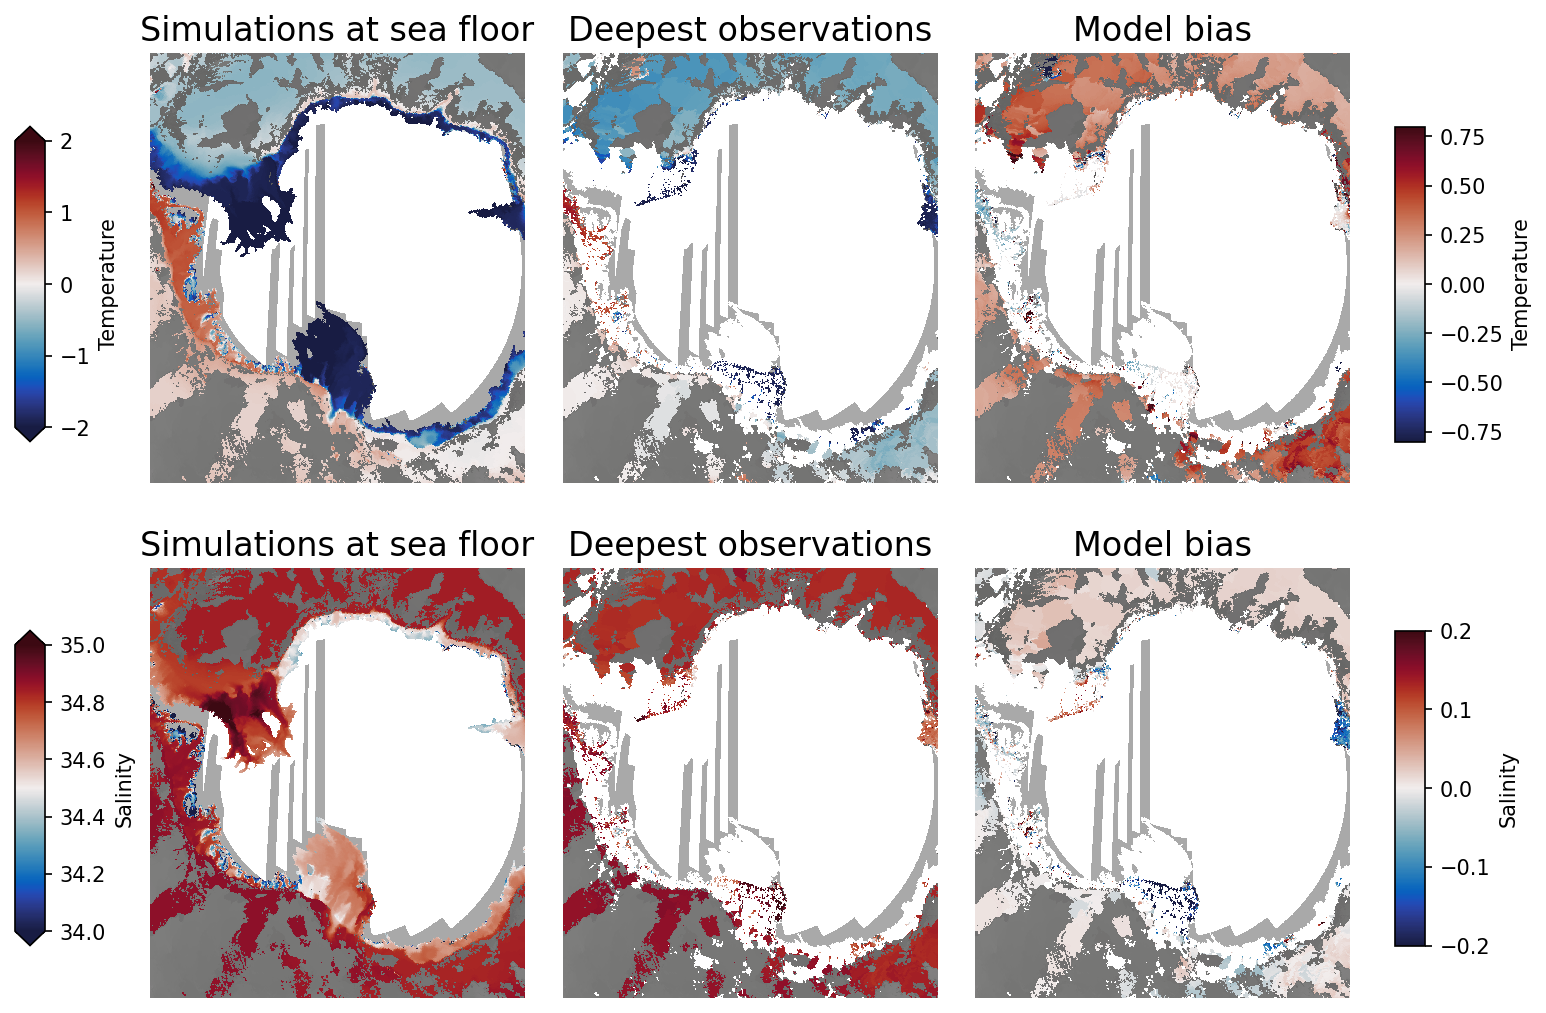

In [23]:
circumpolar_TS_vs_obs(sim_ds, bottom=True, lat_max=-68) 

Interpolating Zhou 2024 dataset to grid
finished interpolation
Creating figure


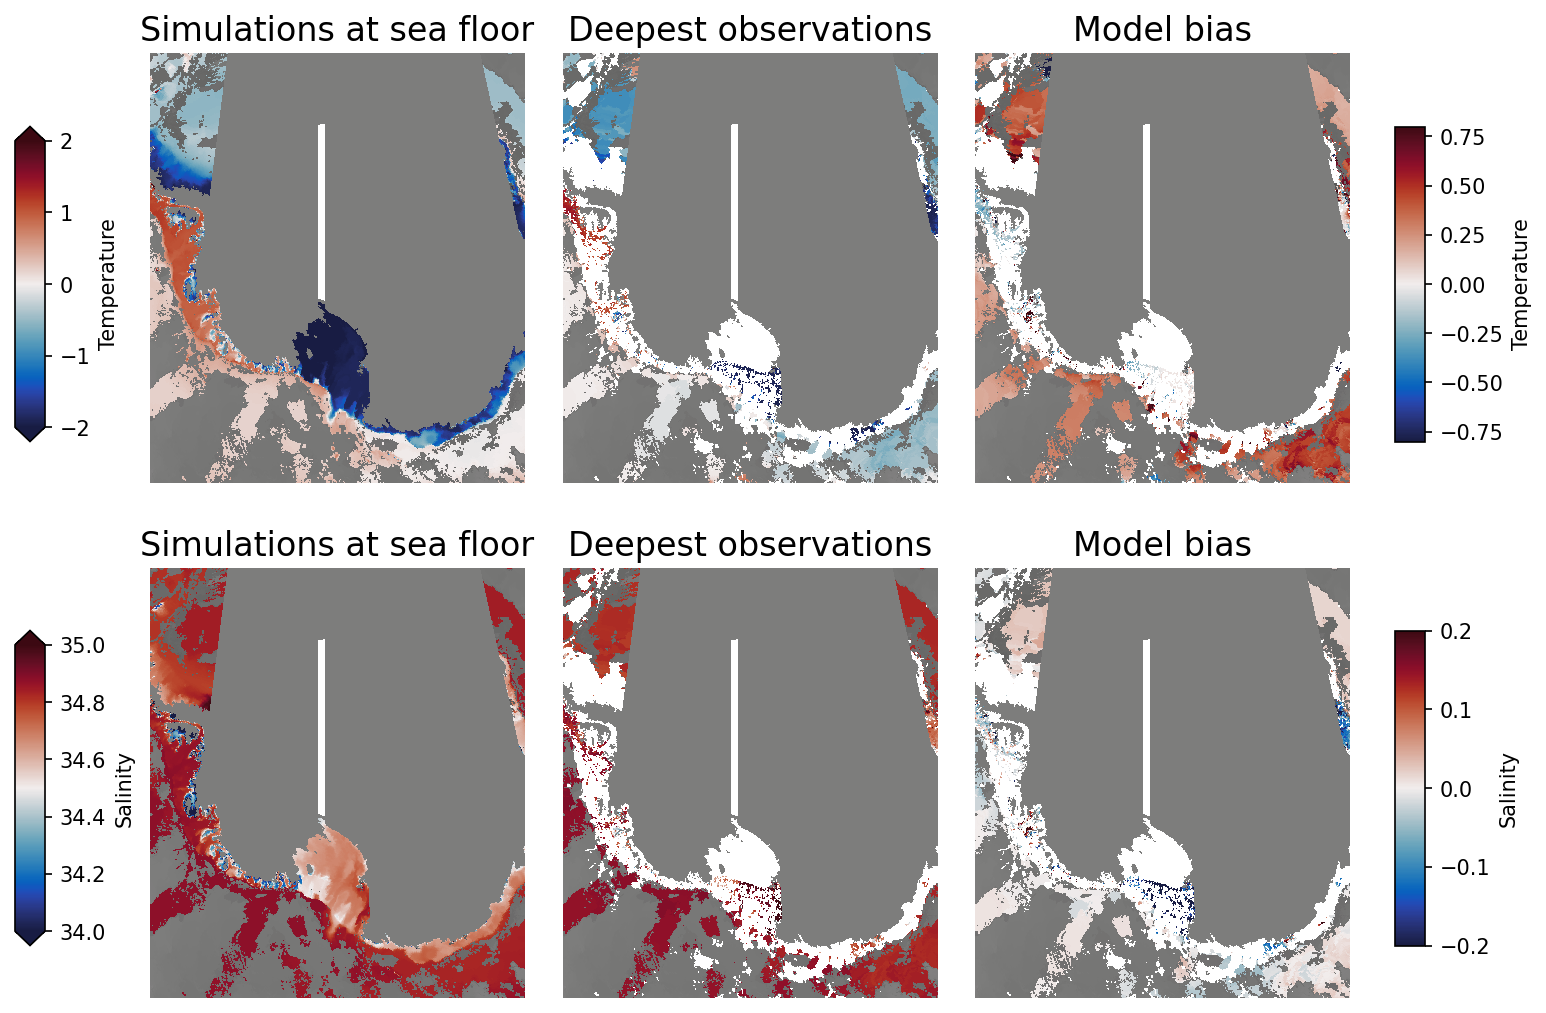

In [30]:
circumpolar_TS_vs_obs(sim_ds, bottom=True, lat_max=-68) 

Interpolating Zhou 2024 dataset to grid
finished interpolation
Creating figure


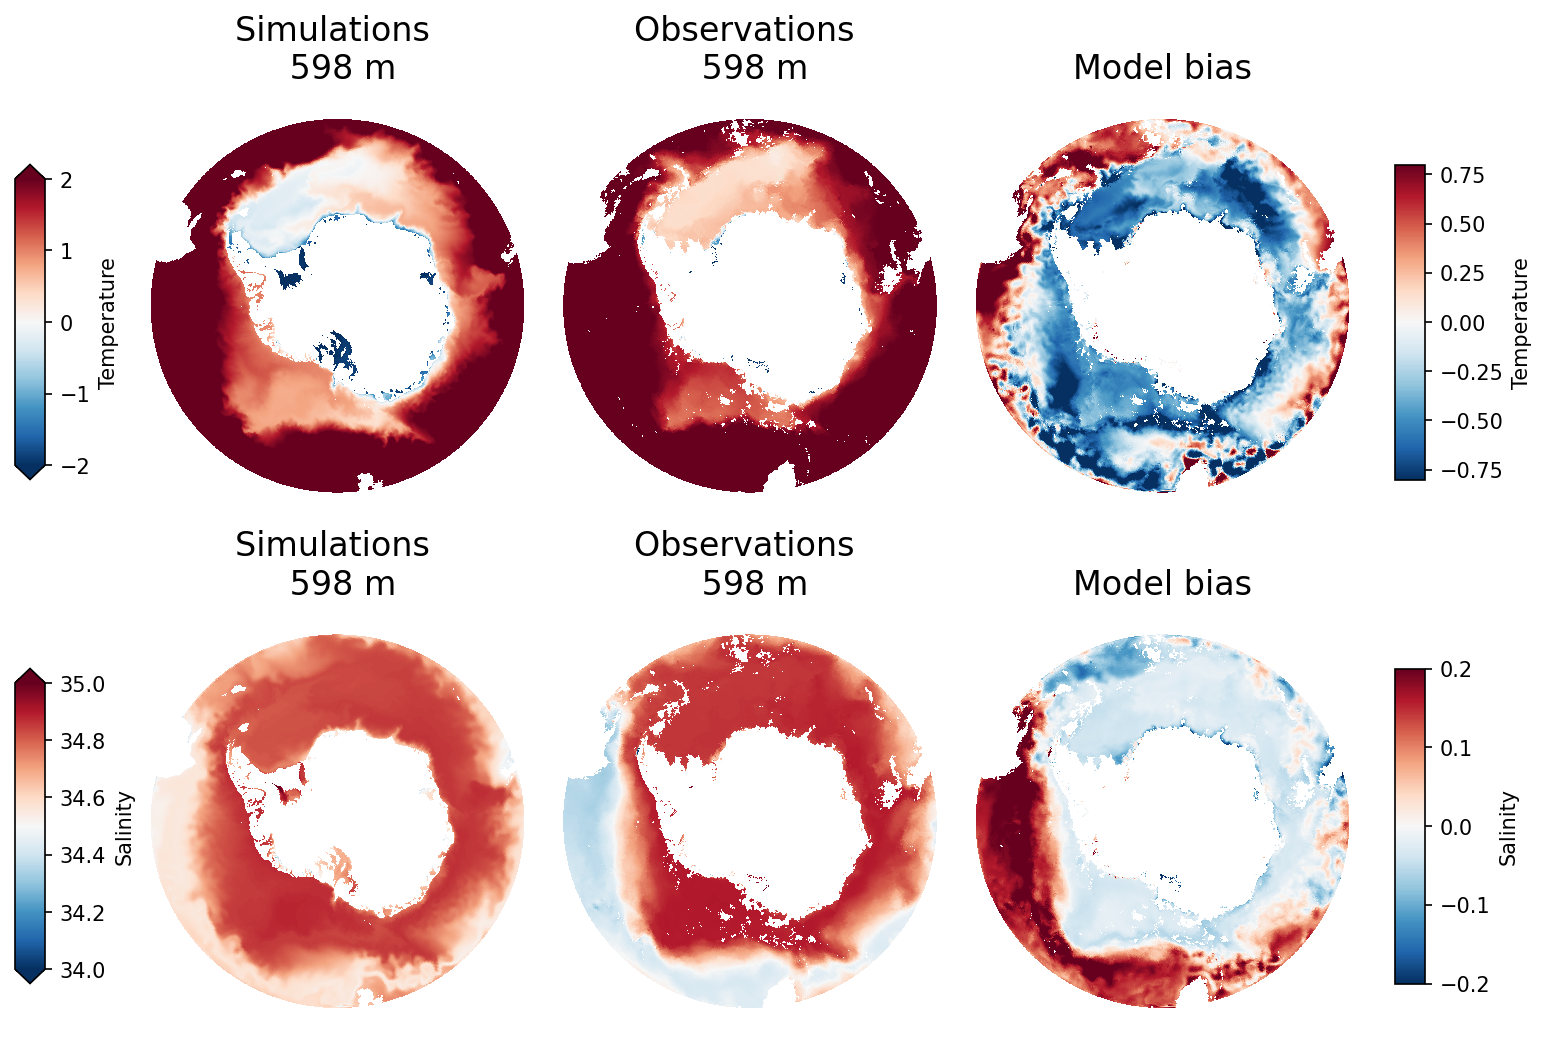

In [7]:
circumpolar_TS_vs_obs(sim_ds, target_depth=600) 

Now plot something similar but finiding the temperature and salinity nearest the seafloor

In [5]:
obs = read_zhou()

In [89]:
# find values at the deepest temperature in the dataset
land_values    = (np.isnan(obs.ConsTemp))
bottom_indices = (obs.z.size - land_values.sum(dim='z') - 1)
obs_bottom     = obs.sel(z=xr.DataArray(bottom_indices.values, dims=("x","y")))

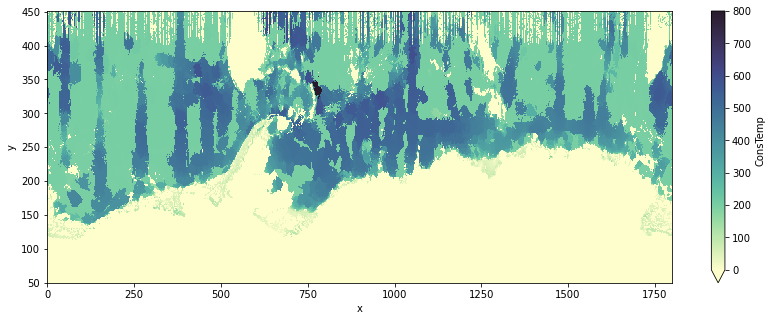

In [106]:
bottom_indices.plot(x='x', y='y', ylim=(50,451), figsize=(14,5), label='grid cell depth', vmin=0, vmax=800, cmap=cmocean.cm.deep)

In [8]:
# once I'm happy that the code is able to filter out only those obs that are near the sea floor, run the model bias code
# over the longer time series as a script. Also create an Amundsen Sea specific plot, so that the evaluation is easier to see there.

Same as above but for the Amundsen Sea

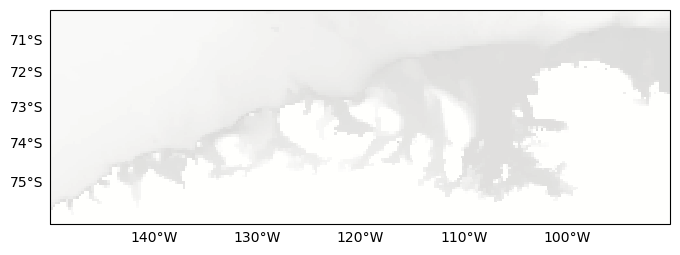

In [39]:
img2 = Amundsen_plot(sim_ds['sbt'], sim_ds, masked=True, make_cbar=False, 
                    title='', vmin=0, vmax=10, ctype=cmocean.cm.gray_r, shade_land=False, dpi=100)

In [38]:
from nemo_python_git.grid import build_ocean_mask
from nemo_python_git.plot_utils import set_colours
from nemo_python_git.utils import extend_grid_edges


# TODO contour ice front
def Amundsen_plot (data, grid, make_cbar=True, masked=False, title=None, titlesize=16, 
                   fig_name=None, return_fig=False, vmin=None, vmax=None, ctype='viridis', change_points=None, 
                   periodic=True, contour=None, shade_land=True, cbar_kwags={}, dpi=150):

    new_fig = ax is None
    if title is None:
        title = data.name

    if not masked:
        # Mask where identically zero
        data = data.where(data!=0)

    if 'nav_lat_grid_T' in grid:
        lat_name = 'nav_lat_grid_T'
        lon_name = 'nav_lon_grid_T'
    elif 'gphit' in grid:
        lat_name = 'gphit'
        lon_name = 'glamt'
    elif 'nav_lat' in grid:
        lat_name = 'nav_lat'
        lon_name = 'nav_lon'
    
    # Get cell edges in polar stereographic coordinates
    if lat_name == 'nav_lat_grid_T':
        import cf_xarray as cfxr
        lon_edges = cfxr.bounds_to_vertices(grid['bounds_nav_lon_grid_T'], 'nvertex_grid_T')
        lat_edges = cfxr.bounds_to_vertices(grid['bounds_nav_lat_grid_T'], 'nvertex_grid_T')
    elif lat_name == 'gphit':
        lon_edges = extend_grid_edges(grid['glamf'], 'f', periodic=True)
        lat_edges = extend_grid_edges(grid['gphif'], 'f', periodic=True)
    elif lat_name == 'nav_lat':
        import cf_xarray as cfxr
        lon_edges = cfxr.bounds_to_vertices(grid['bounds_lon'], 'nvertex')
        lat_edges = cfxr.bounds_to_vertices(grid['bounds_lat'], 'nvertex')

    # Set up colour map
    cmap, vmin, vmax = set_colours(data, ctype=ctype, vmin=vmin, vmax=vmax, change_points=change_points)

    if shade_land:
        ocean_mask = build_ocean_mask(grid)[0]
        ocean_mask = ocean_mask.where(ocean_mask)
        lon_bg, lat_bg = np.meshgrid(np.linspace(lon_edges.min(), lon_edges.max()), np.linspace(lat_edges.min(), lat_edges.max()))
        mask_bg = np.ones(lon_bg.shape)

    if new_fig:
        fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=dpi, subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})
    if shade_land:
        # Shade background in grey
        ax.pcolormesh(lon_bg, lat_bg, mask_bg, cmap=cl.ListedColormap(['DarkGrey']), transform=ccrs.PlateCarree(), rasterized=True)
        # Clear ocean back to white
        ax.pcolormesh(lon_edges, lat_edges, ocean_mask, cmap=cl.ListedColormap(['white']), transform=ccrs.PlateCarree(), rasterized=True)
    # Now plot the data
    img = ax.pcolormesh(lon_edges, lat_edges, data, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), rasterized=True)
    if contour is not None:
        ax.contour(grid[lon_name], grid[lat_name], data, levels=contour, colors=('black'), linewidths=1, linestyles='solid', transform=ccrs.PlateCarree())
    
    ax.set_extent([-90, -150, -76, -65], ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    ax.set_title(title, fontsize=titlesize)
    if make_cbar:
        plt.colorbar(img, **cbar_kwags)
    if return_fig:
        return fig, ax
    elif fig_name is not None:
        fig.savefig(fig_name)
    elif new_fig:
        fig.show()
    else:
        return img



In [46]:
obsd = read_dutrieux(eos='teos10')

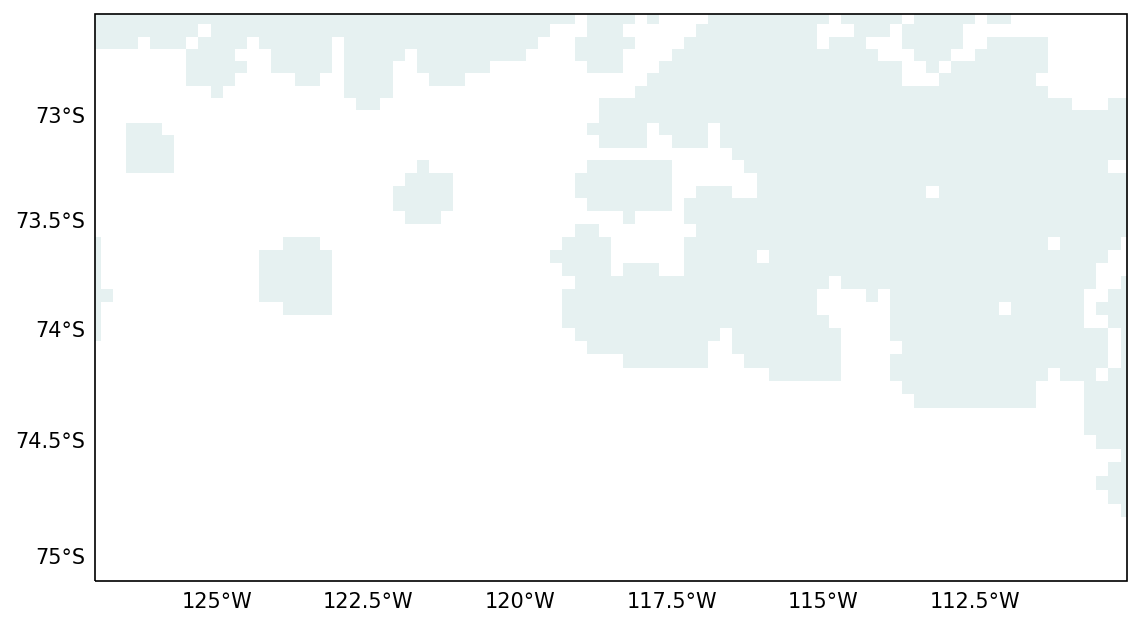

In [66]:
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150, subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})
ax.set_extent([-110, -127, -75.1, -72.5], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

obs_plt = obsd.isel(depth=100)
kwags = {'cmap':cmocean.cm.dense, 'vmin':0.2, 'vmax':1.0}
lonp, latp = np.meshgrid(obsd.lon.values, obsd.lat.values)
ax.pcolormesh(lonp, latp, obs_plt.ConsTemp.values, transform=ccrs.PlateCarree(), rasterized=True, **kwags)

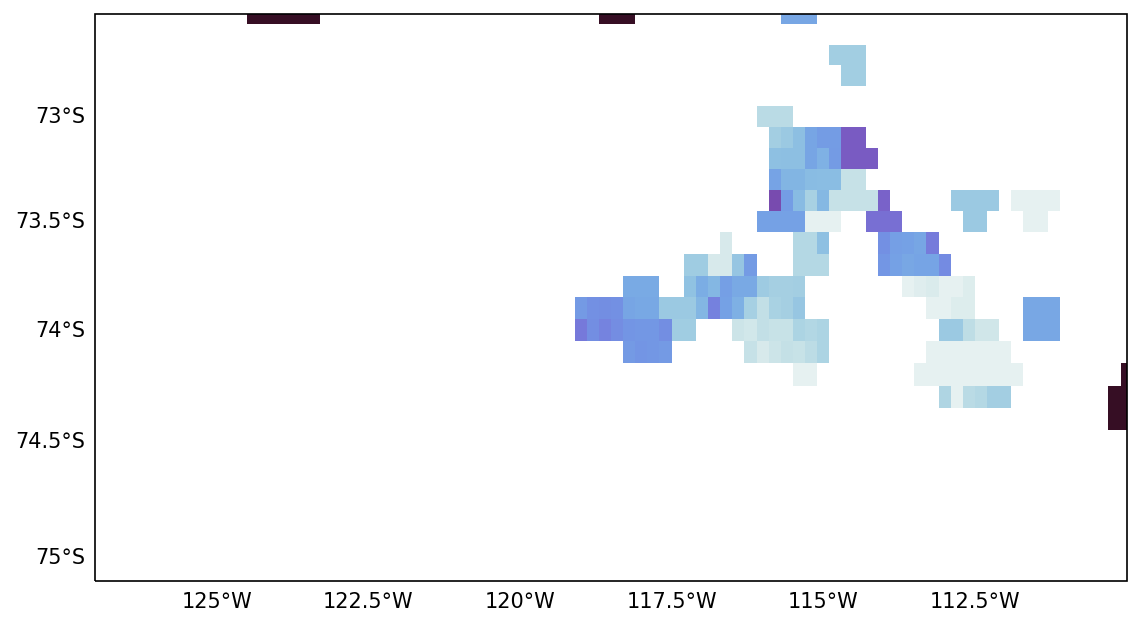

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150, subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})
ax.set_extent([-110, -127, -75.1, -72.5], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

obs_plt = obs.isel(z=70, x=slice(100,450), y=slice(100,250))
kwags = {'cmap':cmocean.cm.dense, 'vmin':0.2, 'vmax':1.0}
ax.pcolormesh(obs_plt.lon.values, obs_plt.lat.values, obs_plt.ConsTemp.values, transform=ccrs.PlateCarree(), rasterized=True, **kwags)

In [5]:
# extract the bottom temperatures and salinities 
depth_bottom_obs = xr.where(obs['ConsTemp'].notnull(),obs['depth'],np.nan).max(dim='z')
depth_bottom_obs = xr.where(depth_bottom_obs < 200, np.nan, depth_bottom_obs) # mask areas shallower than 200 m
bottom_Tobs      = obs['ConsTemp'].where(~np.isnan(depth_bottom_obs)).mean(dim='z')
bottom_Sobs      = obs['AbsSal'].where(~np.isnan(depth_bottom_obs)).mean(dim='z')

obs_bottom = xr.Dataset({'temp':bottom_Tobs, 'salt':bottom_Sobs, 'depth':depth_bottom_obs})

In [6]:
# load nemo grid for interpolation
nemo_ds_ref  = xr.open_dataset(f'{run_folder}eANT025.L121_1m_19790101_19791231_grid_T.nc') # load all the gridT files in the run folder
nemo_ds_ref  = nemo_ds_ref.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})

In [ ]:
obs_interp = interp_latlon_cf(obs_bottom, nemo_ds_ref.isel(x=slice(450, 900), y=slice(130,350)), method='bilinear')

## Also look at moorings:

In [5]:
files = glob.glob('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/shenjie-zhou/mooring/*.nc')

In [30]:
mooring1  = xr.open_dataset(files[0], decode_times=False).squeeze()
mooring2  = xr.open_dataset(files[1], decode_times=False).squeeze()
mooring10 = xr.open_dataset(files[10], decode_times=False).squeeze()

In [31]:
list(mooring10.keys())

['lat',
 'lon',
 'bottom_depth',
 'doi',
 'Instrument_01_date',
 'Instrument_01_depth',
 'Instrument_01_press',
 'Instrument_01_temp',
 'Instrument_01_u',
 'Instrument_01_v',
 'Instrument_02_date',
 'Instrument_02_depth',
 'Instrument_02_press',
 'Instrument_02_temp',
 'Instrument_02_u',
 'Instrument_02_v']

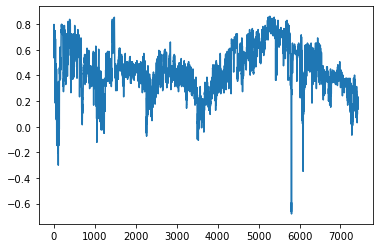

In [34]:
plt.plot(mooring10.Instrument_01_temp.values)

In [15]:
a = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/observations/pierre-dutrieux/110036.nc').squeeze()